In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("../data/processed/probability_of_default.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31679 entries, 0 to 31678
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      31679 non-null  int64  
 1   income                   31679 non-null  int64  
 2   home_ownership_type      31679 non-null  object 
 3   employment_length        31679 non-null  float64
 4   loan_amount              31679 non-null  int64  
 5   loan_interest_rate       28632 non-null  float64
 6   is_default               31679 non-null  int64  
 7   loan_to_income_ratio     31679 non-null  float64
 8   has_defaulted_before     31679 non-null  int64  
 9   credit_history_length    31679 non-null  int64  
 10  debt_to_stability_ratio  31679 non-null  float64
dtypes: float64(4), int64(6), object(1)
memory usage: 2.7+ MB


In [3]:
categorical_column = df.drop(columns=['is_default']).select_dtypes(include='object').columns.to_list()

encoder = OneHotEncoder(handle_unknown='ignore')
joblib.dump(encoder, '../models/encoder.pkl')

categorical_values = encoder.fit_transform(df[categorical_column].values).toarray()

encoder.get_feature_names_out(categorical_column)

array(['home_ownership_type_MORTGAGE', 'home_ownership_type_OTHER',
       'home_ownership_type_OWN', 'home_ownership_type_RENT'],
      dtype=object)

In [4]:
numerical_column = df.drop(columns=['is_default']).select_dtypes(exclude='object').columns.to_list()

scaler = MinMaxScaler()
joblib.dump(scaler, '../models/scaler.pkl')

# Replace inf/-inf with nan, then fill nan with column mean before scaling
numerical_df = df[numerical_column].replace([np.inf, -np.inf], np.nan)
numerical_df = numerical_df.fillna(numerical_df.mean())
numerical_values = scaler.fit_transform(numerical_df.values)

numerical_values

array([[0.01351351, 0.00275078, 0.12195122, ..., 0.        , 0.        ,
        0.04283037],
       [0.06756757, 0.00275078, 0.02439024, ..., 0.        , 0.03571429,
        0.67011689],
       [0.04054054, 0.03020949, 0.09756098, ..., 0.        , 0.        ,
        0.2958865 ],
       ...,
       [0.60810811, 0.03536721, 0.07317073, ..., 0.        , 0.92857143,
        0.29606496],
       [0.48648649, 0.07171684, 0.12195122, ..., 0.        , 0.85714286,
        0.04488266],
       [0.62162162, 0.01866603, 0.04878049, ..., 0.        , 1.        ,
        0.12483269]])

In [5]:
x = np.concatenate([categorical_values, numerical_values], axis=1)
x.shape

(31679, 13)

In [6]:
y = df['is_default'].values
y.shape

(31679,)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((22175, 13), (9504, 13), (22175,), (9504,))

In [8]:
# Save x_test, x_train, y_test, y_train as pickle files
joblib.dump(x_train, '../models/x_train.pkl')
joblib.dump(x_test, '../models/x_test.pkl')
joblib.dump(y_train, '../models/y_train.pkl')
joblib.dump(y_test, '../models/y_test.pkl')

['../models/y_test.pkl']

In [9]:
model = RandomForestClassifier(random_state=42, class_weight='balanced').fit(x_train, y_train)
joblib.dump(model, f'../models/default_probability_model.pkl')

single_tree = model.estimators_[0]  # Select first tree from the forest

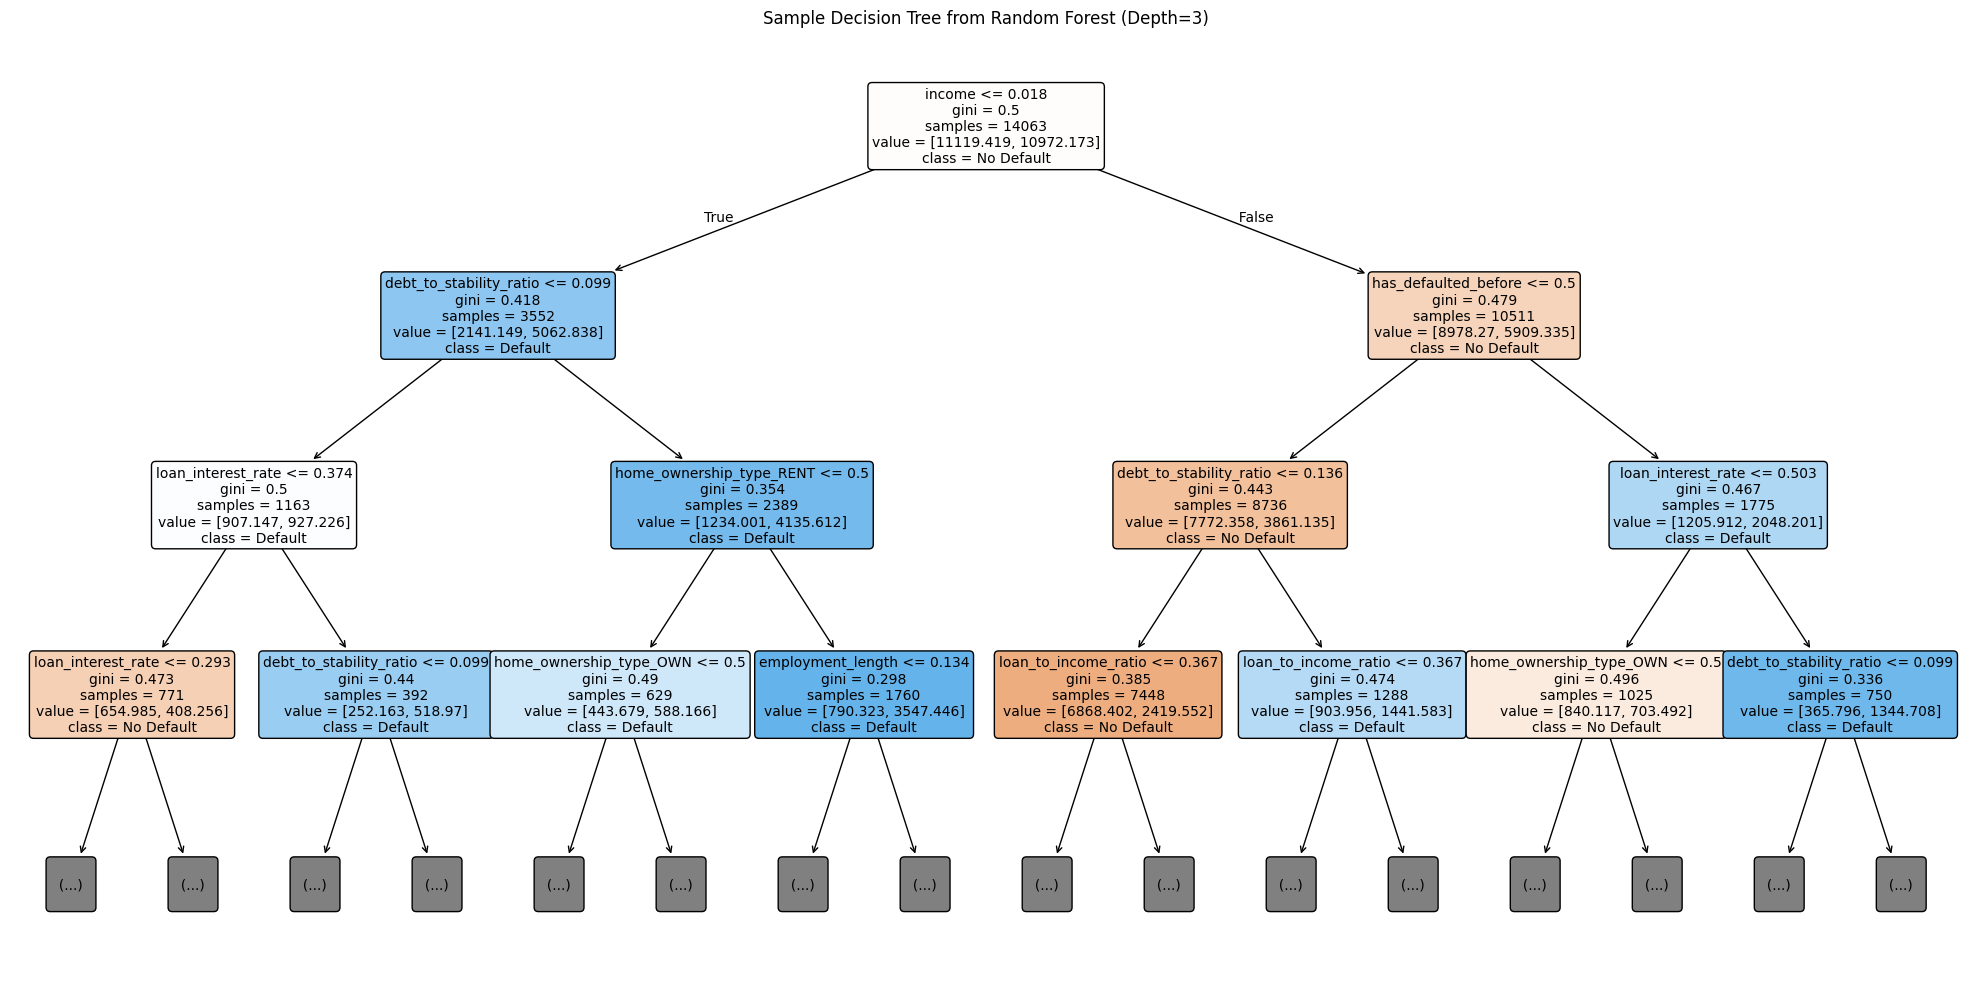

In [10]:
features = list(encoder.get_feature_names_out(categorical_column)) + numerical_column

plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=features,
    class_names=["No Default", "Default"],
    filled=True,
    rounded=True,
    max_depth=3,  # Limit depth for readability
    fontsize=10
)
plt.title("Sample Decision Tree from Random Forest (Depth=3)")
plt.tight_layout()
plt.show()